# PostSelecttML: Modeling Notebook Locally - Further Augmented Data
### by Dolci Key 

 In following this notebook, I will run the current best model locally. 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 


import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, metrics
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.metrics import Accuracy, Recall
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from sklearn.utils import class_weight


from PIL import Image
import pydot
import graphviz

import pickle
from timeit import default_timer as timer

import os
import gc


## Importing Data 

Here we have the train, validation, and hold out set directories and then the paths to the reject(X) and select(y/target). 

In [2]:
# Train

train_dir = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TRAIN'

# Split X and Y if needed 
train_x = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TRAIN/reject'
train_y = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TRAIN/select'

# Validation 
validation_dir = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/VALIDATION'

# Split X and Y if needed 
test_x = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/VALIDATION/reject'
test_y = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/VALIDATION/select'

# Test/Hold Out Set 

test_dir = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TEST'

# Split X and Y if needed 
hold_x = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TEST/reject'
hold_y = '/Volumes/DOLCI KEY 2019/Neural Network/compressed/TEST/select'

## Augmenting the Data 
In the last notebook, we did one horizontal flip to augment the data, in this notebook, we will take a look at how augmentation of the minority can change the model. 

## Setting up the Training, Validation, and Test sets. 
for the training set, we will use the horizontal_flip to augment the minority class as well as adding zoom range up to 30%. We have included the target size of the images which are 500,333 pixels each, set the color mode to RGB (color), and the class mode is binary. 

In [3]:
#Training
train_set = image.ImageDataGenerator(rescale = 1/255, 
                                     horizontal_flip = True, 
                                     rotation_range = 30, 
                                     zoom_range = [0.3, 1.2], 
                                     brightness_range = (-20,50)).flow_from_directory(train_dir,
                                                                  target_size = (500,333), 
                                                                  color_mode='rgb',
                                                                  class_mode = 'binary')



Found 1954 images belonging to 2 classes.


In [4]:
# Validation Set
validation_set = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(validation_dir,
                                                                shuffle= False,
                                                                target_size = (500,333), 
                                                                color_mode='rgb',
                                                                class_mode='binary')

Found 698 images belonging to 2 classes.


In [5]:
# Test set / Hold out Set                                                               
test_set = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(test_dir,
                                                                shuffle = False, 
                                                                target_size = (500,333), 
                                                                color_mode='rgb',
                                                                class_mode='binary')

Found 769 images belonging to 2 classes.


## Vanilla Model 

First, I will run a very simple model to get an idea of a baseline, or a starting point to really work from. The metrics I am most interested in is recall as I would much rather get a bad photo mixed in with the good ones occasionally, rather than a good one tossed out with the bad. 

In [33]:
# Vanilla model 

HEIGHT = 500
WIDTH = 333
DEPTH = 3

model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(HEIGHT, WIDTH, DEPTH)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [34]:
model.compile(loss='binary_crossentropy',  
                optimizer='adam',
                metrics = ['binary_accuracy', 'Recall', 'Precision'])

In [ ]:
# Start timer to keep track of how long model is running for, not using class weights for this model
start = timer()

vanilla_aug = model.fit(train_set, epochs = 5, validation_data = validation_set)
end = timer()

# Take difference of time 
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/5
62/62 [==============================] - 248s 4s/step - loss: 3.8067 - binary_accuracy: 0.8818 - recall: 0.0363 - precision: 0.1346 - val_loss: 0.7356 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/5
62/62 [==============================] - 258s 4s/step - loss: 0.3441 - binary_accuracy: 0.9012 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.7018 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/5
62/62 [==============================] - 256s 4s/step - loss: 0.3394 - binary_accuracy: 0.9012 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.7383 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/5
26/62 [===========>..................] - ETA: 2:11 - loss: 0.3400 - binary_accuracy: 0.9014 - recall: 0.0000e+00 - precision: 0.0000e+00

## Model Summary, Evaluation, and Prediction on Unseen Data

In [ ]:
model.summary()

In [ ]:
model.evaluate(test_set)

In [ ]:
model.save('MODELS/vanilla_aug\assets')

In [ ]:
def score_image(img_dir, model):
    
    image = tf.keras.preprocessing.image.load_img(img_dir)
    input_arr = keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    predictions = model.predict(input_arr)
    return predictions, image

In [ ]:
img_sel = 'THREE/DKP_4193_00135.jpg'
img_rej = 'THREE/DKP_3894_00033.jpg'

In [ ]:
score_image(img_sel, model)

In [ ]:
score_image(img_rej, model)

In [ ]:
model_ = vanilla_aug.history
epochs = vanilla_aug.epoch
    
plt.figure()
plt.plot(epochs, model_['loss'], label='Training loss')
plt.plot(epochs, model_['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
    
plt.show();

## Vanilla Model with Class Weights 

So now that I have an idea, let's see if weighting the classes helps with the scores. 

### Weighting the classes 
For later usage, we will weight the classes to help with class imbalance. 

In [14]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', [0, 1], train_set.classes)
weights = dict(zip([0, 1], weights))
weights

{0: 0.5547984099943214, 1: 5.062176165803109}

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(HEIGHT, WIDTH, DEPTH)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [16]:
model.compile(loss ='binary_crossentropy',  
                optimizer = optimizers.RMSprop(lr = 0.0001), 
                weighted_metrics = 'Recall',
                metrics = 'binary_accuracy')

In [17]:
# Start timer to keep track of how long model is running for, not using class weights for this model
start = timer()

vanilla = model.fit(train_set, epochs = 5, class_weight = weights,
                            validation_data = validation_set)
end = timer()

# Take difference of time 
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/5
62/62 [==============================] - 436s 7s/step - loss: 2.3197 - binary_accuracy: 0.2001 - recall: 0.8808 - val_loss: 0.6933 - val_binary_accuracy: 0.3195 - val_recall: 1.0000
Epoch 2/5
62/62 [==============================] - 297s 5s/step - loss: 0.6932 - binary_accuracy: 0.2805 - recall: 0.7720 - val_loss: 0.6932 - val_binary_accuracy: 0.3209 - val_recall: 1.0000
Epoch 3/5
62/62 [==============================] - 289s 5s/step - loss: 0.7172 - binary_accuracy: 0.3234 - recall: 0.6891 - val_loss: 0.6932 - val_binary_accuracy: 0.3181 - val_recall: 1.0000
Epoch 4/5
62/62 [==============================] - 274s 4s/step - loss: 0.6932 - binary_accuracy: 0.3306 - recall: 0.7461 - val_loss: 0.6932 - val_binary_accuracy: 0.3181 - val_recall: 1.0000
Epoch 5/5
62/62 [==============================] - 280s 5s/step - loss: 0.6947 - binary_accuracy: 0.3337 - recall: 0.6684 - val_loss: 0.6932 - val_binary_accuracy: 0.3181 - val_recall: 1.0000
Total Time Elapsed:  27  minutes  1  sec

## Model Summary, Evaluation, and Prediction on Unseen Data

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 500, 333, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 250, 166, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1328000)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               169984128 
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 169,985,153
Trainable params: 169,985,153
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.evaluate(test_set)

25/25 [==============================] - 18s 740ms/step - loss: 0.6933 - binary_accuracy: 0.1638 - recall: 1.0000


[0.6932662129402161, 0.16384916007518768, 1.0]

## Iterative Modeling

After running the vanilla models, I added up to 6 convelutional layers. 

In [20]:
HEIGHT = 500
WIDTH = 333
DEPTH = 3

model = models.Sequential()

model.add(layers.Conv2D(32, 3, activation = 'relu', input_shape=(HEIGHT, WIDTH, DEPTH)))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation="sigmoid", padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, kernel_size=(3, 3), activation="sigmoid", padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())

model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(256, activation="sigmoid"))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation="sigmoid"))

In [21]:
model.compile(loss='binary_crossentropy',  
                optimizer=optimizers.RMSprop(lr= 0.0001),
                metrics = ['accuracy', 'binary_accuracy', 'Recall'])

In [22]:
# Start timer to keep track of how long model is running for
start = timer()

model_script_vi = model.fit(train_set, epochs = 10, class_weight = weights,
                            validation_data = validation_set)
end = timer()

# Take difference of time 
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/10
62/62 [==============================] - 303s 5s/step - loss: 0.7378 - accuracy: 0.5691 - binary_accuracy: 0.5691 - recall: 0.4974 - val_loss: 0.7544 - val_accuracy: 0.3181 - val_binary_accuracy: 0.3181 - val_recall: 1.0000
Epoch 2/10
62/62 [==============================] - 293s 5s/step - loss: 0.7421 - accuracy: 0.4969 - binary_accuracy: 0.4969 - recall: 0.4456 - val_loss: 0.6709 - val_accuracy: 0.6819 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00
Epoch 3/10
62/62 [==============================] - 297s 5s/step - loss: 0.7224 - accuracy: 0.5333 - binary_accuracy: 0.5333 - recall: 0.4922 - val_loss: 0.6758 - val_accuracy: 0.6819 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00
Epoch 4/10
62/62 [==============================] - 298s 5s/step - loss: 0.7179 - accuracy: 0.4969 - binary_accuracy: 0.4969 - recall: 0.5233 - val_loss: 0.6670 - val_accuracy: 0.6819 - val_binary_accuracy: 0.6819 - val_recall: 0.0000e+00
Epoch 5/10
62/62 [==============================

## Model Summary, Evaluation, and Prediction on Unseen Data

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 498, 331, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 249, 165, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 247, 163, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 123, 81, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 123, 81, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 123, 81, 64)       18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 61, 40, 64)       

In [24]:
model.evaluate(test_set)

25/25 [==============================] - 25s 1s/step - loss: 0.7101 - accuracy: 0.1625 - binary_accuracy: 0.1625 - recall: 1.0000   


[0.7101365923881531, 0.16254876554012299, 0.16254876554012299, 1.0]

In [25]:
model.save('SCRIPTS/model_iv\assets')

INFO:tensorflow:Assets written to: SCRIPTS/model_ivssets/assets


In [27]:
model.predict(test_set)

array([[0.5114897 ],
       [0.51141626],
       [0.51132   ],
       [0.51076645],
       [0.51070416],
       [0.5108788 ],
       [0.5108687 ],
       [0.51061857],
       [0.5107275 ],
       [0.51098585],
       [0.51081854],
       [0.5111382 ],
       [0.51077557],
       [0.5107641 ],
       [0.5110167 ],
       [0.5111759 ],
       [0.512331  ],
       [0.5132998 ],
       [0.51328677],
       [0.51339346],
       [0.5132033 ],
       [0.51277244],
       [0.5126459 ],
       [0.512987  ],
       [0.51301765],
       [0.51279   ],
       [0.5126571 ],
       [0.51256573],
       [0.5124406 ],
       [0.5126403 ],
       [0.5126764 ],
       [0.5127487 ],
       [0.51266193],
       [0.51283765],
       [0.51325643],
       [0.5132616 ],
       [0.5132149 ],
       [0.5130938 ],
       [0.5132728 ],
       [0.51306635],
       [0.5132154 ],
       [0.51325625],
       [0.5131352 ],
       [0.51296705],
       [0.5134277 ],
       [0.51296484],
       [0.5129067 ],
       [0.512

The model seems like it may be overfitting to the training data. 

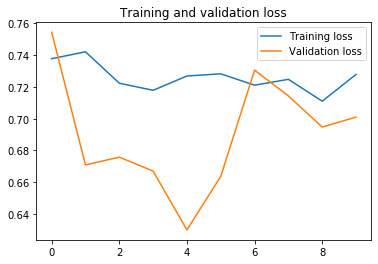

In [26]:
model_ = model_script_vi.history
epochs = model_script_vi.epoch
    
plt.figure()
plt.plot(epochs, model_['loss'], label='Training loss')
plt.plot(epochs, model_['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
    
plt.show();

## Testing Unseen Data

As we can see here, I have a lot of work left to do. 
The model rejects most images with around a .506 to .507 probability of being selected, infact, it seems to be scoring the rejected images higher than the selected images. 



reject image:  [[0.50731903]]


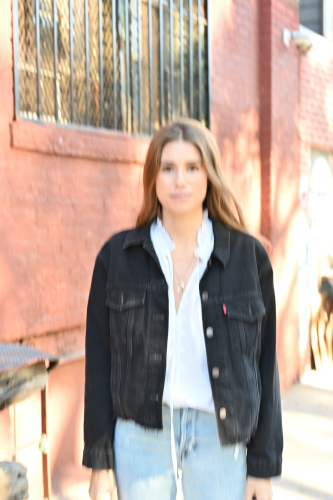

In [28]:
img_dir = 'THREE/DKP_3869_00015.jpg'
image = tf.keras.preprocessing.image.load_img(img_dir)
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = model.predict(input_arr)
predictions

print ('reject image: ', predictions)
image

reject image:  [[0.5072707]]


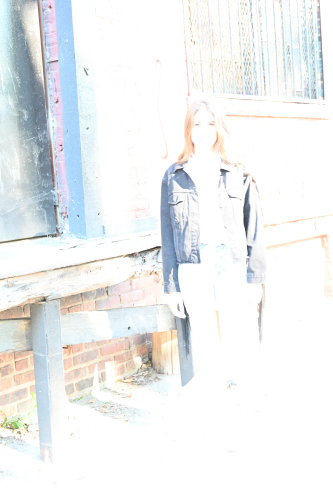

In [29]:
img_dir = 'THREE/DKP_3894_00033.jpg'
image = tf.keras.preprocessing.image.load_img(img_dir)
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = model.predict(input_arr)
predictions

print ('reject image: ', predictions)
image

reject image:  [[0.50554883]]


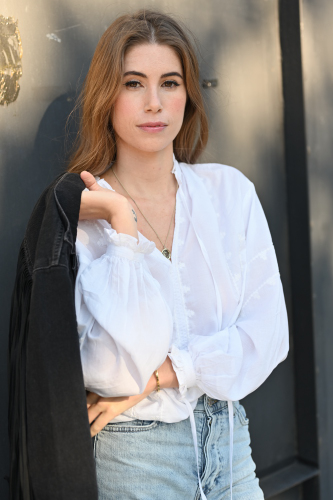

In [32]:
img_dir = 'THREE/DKP_4193_00135.jpg'
image = tf.keras.preprocessing.image.load_img(img_dir)
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = model.predict(input_arr)


print ('select image: ', predictions)
image